In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imread, imresize

In [2]:
def set_x(image):
    return tf.transpose(set_y(image))


def set_y(image):
    [height, width, _] = image.get_shape().as_list()
    rows = list(range(height))
    rows = [tf.ones((width,)) * x for x in rows]
    return tf.stack(rows)


In [13]:
def get_attention_region_param(conv_layer, image_size=448.0):
    """output the three region proposal parameters, ie, tx, ty, tl"""
    anp_pool = tf.nn.max_pool(conv_layer, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                            padding="SAME") # padding setting may not correct here
                                            # need investigation
    anp_pool_flat = tf.contrib.layers.flatten(anp_pool)
    
    # gaussian initializer is used here in the original work
    get_abc1 = tf.layers.dense(inputs=anp_pool_flat, units=1024, 
                               activation=tf.nn.tanh,
                              kernel_initializer=tf.contrib.layers.xavier_initializer()
                               )
    get_abc2 = tf.layers.dense(inputs=get_abc1, units=3,
                              activation=tf.nn.sigmoid,
                              kernel_initializer=tf.contrib.layers.xavier_initializer()
                              )
    # get448 = (0 +   448 * get_abc2)^1
    # the original image size is 448
    # get448 has three elements, tx, ty, tl
    get448 = tf.multiply(get_abc2, image_size)
    return get448
    
def get_tx_ty_tl(param):
    return param[:, 0], param[:, 1], param[:, 2]

def get_corners(param):
    tx, ty, tl = get_tx_ty_tl(param)
    tx_top_left = tx - tl
    ty_top_left = ty - tl
    tx_bottom_right = tx + tl
    ty_bottom_right = ty + tl
    return tx_top_left, ty_top_left, tx_bottom_right, ty_bottom_right
    

        
    
def get_attention_region(image, param, k=1):
    """get the attention region given image and tx, ty, tl"""
    # get tx, ty, tl, I am not sure that tensor indexing is working
    # this way, but I will use it for now
    # also the order of tx, ty, tl in param may be different
    tx, ty, tl = get_tx_ty_tl(param)
    tx_top_left, ty_top_left, tx_bottom_right, ty_bottom_right = get_corners(param)
    
    [_, height, width, _] = image.get_shape().as_list()
    tx_top_left = tf.map_fn(lambda x: tf.ones((height, width)) * x, tx_top_left)
    ty_top_left = tf.map_fn(lambda x: tf.ones((height, width)) * x, ty_top_left)
    tx_bottom_right = tf.map_fn(lambda x: tf.ones((height, width)) * x, tx_bottom_right)
    ty_bottom_right = tf.map_fn(lambda x: tf.ones((height, width)) * x, ty_bottom_right)
    
    h = lambda x: tf.divide(1.0, tf.add(1.0, tf.exp(tf.multiply(x, -k))))
    # construct the mask image, I will use the most simple and obvious 
    # implementation for now, which may not even be able to run on 
    # tensorflow
    # attention_mask = tf.zeros_like(image)
    # use layers to replace this
    mask_x = tf.map_fn(set_x, image)
    mask_y = tf.map_fn(set_y, image)
    
    mask_x1 = h(tf.subtract(mask_x, tx_top_left))
    mask_x2 = h(tf.subtract(mask_x, tx_bottom_right))
    
    mask_y1 = h(tf.subtract(mask_y, ty_top_left))
    mask_y2 = h(tf.subtract(mask_y, ty_bottom_right))
    
    mask_x = mask_x1 - mask_x2
    mask_y = mask_y1 - mask_y2
    attention_mask = tf.multiply(mask_x, mask_y)
    attention_mask = tf.stack([attention_mask, attention_mask, attention_mask], axis=3)
    
    # element wise multiplication of the original image and attention_mask
    return tf.multiply(image, attention_mask)



def zoom_attention_region(param, attention_image):
    """zoom the proposed attention regin to the original image size,
    This implementation is not working of course, 
    """
    tx, ty, tl = get_tx_ty_tl(param)
    tx_top_left, ty_top_left, tx_bottom_right, ty_bottom_right = get_corners(param)

    [_, height, width, _] = attention_image.get_shape().as_list()
    upsampling_factor = tf.divide(height / 2, tl)
    
    # construct the amplifid image
    image = tf.zeros_like(attention_image)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for alpha in range(2):
                for beta in range(2):
                    m = y / upsampling_factor + alpha
                    n = x / upsampling_factor + beta
                    image[y, x] += attention_image[ty_top_left + m, tx_top_left + n] / 4
                    # the original equation in the paper confuses me, so I just 
                    # use the mean of of nearest four points
                    #image[y, x] += (tf.abs(1 - alpha - y / upsampling_factor) *
                    #               tf.abs(1 - beta - x / upsampling_factor) *
                    #               attention_image[ty_top_left + m, tx_top_left + n])
    return image

    # element-wise multiplication between the original image at coarse
    # scales and an attention mask
    
    


In [14]:
path = "./th.jpg"
image = imread(path)
image = imresize(image, (448, 448))
image_copy = image.copy()
#plt.imshow(image)
image = np.expand_dims(image, axis=0)
image = np.concatenate((image, image), axis=0)
print(image.shape)


(2, 448, 448, 3)


In [15]:
def neural_net_image_input(image_shape):
    x = tf.placeholder(tf.float32, shape=(None, 
                                         image_shape[0],
                                         image_shape[1],
                                         image_shape[2]))
    return x

image_input = neural_net_image_input([448, 448, 3])
attention_params = get_attention_region_param(image_input)
tx, ty, tl = get_tx_ty_tl(attention_params)
corners = get_corners(attention_params)
attention_region = get_attention_region(image_input, attention_params)
mask_y = tf.map_fn(set_y, image_input)
mask_x = tf.map_fn(set_x, image_input)
tx_top_left = tx - tl
ty_top_left = ty - tl
tx_bottom_right = tx + tl
ty_bottom_right = ty + tl
k = 1
h = lambda x: tf.divide(1.0, tf.add(1.0, tf.exp(tf.multiply(x, -k))))
print("type of mask x is {}".format(mask_x.get_shape()))
print("type of tx_top_left is {}".format(tx_top_left.get_shape()))
tx_top_left = tf.map_fn(lambda x: tf.ones((448, 448)) * x, tx_top_left)
mask_x1 = mask_x - tx_top_left



type of mask x is (?, 448, 448)
type of tx_top_left is (?,)


In [16]:
#tf.reset_default_graph()
images = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    params = sess.run(corners, feed_dict = {image_input: image})
    #ys = sess.run(ys, feed_dict={image_input: image})
    #xs = sess.run(xs, feed_dict={image_input: image})
    attention_region = sess.run(attention_region, feed_dict={image_input:image})
    for i in range(attention_region.shape[0]):
        images.append(np.squeeze(attention_region[i]))
    
 
    

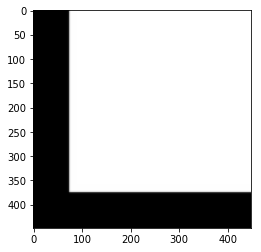

In [17]:
plt.imshow(images[1])

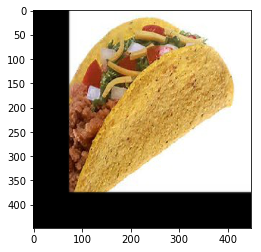

In [20]:
plt.imshow(np.multiply(image_copy, images[1]).astype(np.uint8))